<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    Mini-Challenge 2:<br>Paper-Studium und Umsetzung
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Gabriel Torres Gamez im FS 2023.
</p>

## Ziel
Vertiefung in ein eher aktuelles Paper aus der Forschung und Umsetzung eines darin <br>
beschriebenen oder verwandten Tasks - gemäss Vereinbarung mit dem Fachcoach.  

Beispiel: Implementiere, trainiere und validiere ein Deep Learning Modell für Image <br>
Captioning wie beschrieben im Paper Show and Tell.

## Setup
Hier wird vor der Bearbeitung alles aufgesetzt.

In [1]:
# Standard Libraries
import os
import sys
import logging
import warnings

from collections import defaultdict

# 3rd Party Libraries
import matplotlib as mpl
import nltk
import numpy as np
import pandas as pd
import pytorch_lightning as li
import torch
import torchaudio
import torchmetrics
import torchvision
import tqdm
import wandb

from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize as nltk_word_tokenize
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchtext.data.metrics import bleu_score

# Print information about the environment
print("Packages: ")
print(f" | Python Version: {sys.version}")
print(f" | Matplotlib Version: {mpl.__version__}")
print(f" | NLTK Version: {nltk.__version__}")
print(f" | Numpy Version: {np.__version__}")
print(f" | Pandas Version: {pd.__version__}")
print(f" | PyTorch Lightning Version: {li.__version__}")
print(f" | PyTorch Version: {torch.__version__}")
print(f" | Torchaudio Version: {torchaudio.__version__}")
print(f" | Torchmetrics Version: {torchmetrics.__version__}")
print(f" | Torchvision Version: {torchvision.__version__}")
print(f" | tqdm Version: {tqdm.__version__}")
print(f" | Wandb Version: {wandb.__version__}")
print()

print("Backends: ")
print(f" | CUDA: {torch.cuda.is_available()}")
print(f"   | CUDA Built: {torch.backends.cuda.is_built()}")
print(f" | MPS: {torch.backends.mps.is_available()}")
print(f"   | MPS Built: {torch.backends.mps.is_built()}")
print()

print("Ressources: ")
print(f" | CPU Threads: {torch.get_num_threads()}")
for i in range(torch.cuda.device_count()):
    print(f" | GPU {i+1}: {torch.cuda.get_device_name(i)}\n")

# Settings
torch.set_float32_matmul_precision("high")
nltk.download('punkt')
torch.manual_seed(0)

# silent warnings
%env WANDB_SILENT=True
warnings.filterwarnings("ignore")
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

# Final message
print("Setup complete!\n")

Packages: 
 | Python Version: 3.11.6 (main, Oct  2 2023, 13:45:54) [Clang 15.0.0 (clang-1500.0.40.1)]
 | Matplotlib Version: 3.8.2
 | NLTK Version: 3.8.1
 | Numpy Version: 1.26.2
 | Pandas Version: 2.1.2
 | PyTorch Lightning Version: 2.1.2
 | PyTorch Version: 2.1.1
 | Torchaudio Version: 2.1.1
 | Torchmetrics Version: 1.2.0
 | Torchvision Version: 0.16.1
 | tqdm Version: 4.66.1
 | Wandb Version: 0.16.0

Backends: 
 | CUDA: False
   | CUDA Built: False
 | MPS: True
   | MPS Built: True

Ressources: 
 | CPU Threads: 8
env: WANDB_SILENT=True
Setup complete!



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gabriel.torres/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Hyperparameters

In [2]:
# Files
img_path = "data/images"
ann_file = "data/captions.txt"

# Tokenizer
tokenizer = nltk_word_tokenize

# Data Loader 
batch_size = 64
num_workers = 0 # number of CPU cores - 1
val_ratio = 0.15
test_ratio = 0.15

#### Settings

In [3]:
# Special Tokens
start_token = "<start>"
end_token = "<end>"
pad_token = "<pad>"
unk_token = "<unk>"
special_tokens = [start_token, end_token, pad_token, unk_token]

## Arbeitsschritte

### Schritt 1: Daten 
Für diese Mini Challenge wird der Flickr8k Datensatz verwendet. 

#### Vorbereitungen

In [4]:
# read annotations as df
ann = pd.read_csv(ann_file, sep=",")
ann

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [5]:
all_tokens_set = set(ann["caption"].apply(tokenizer).explode().tolist())
vocab_size = len(all_tokens_set) + len(special_tokens) 
max_num_tokens = ann["caption"].apply(tokenizer).apply(len).max() + 2  # + start & end token

print(f"Vocabulary Size:\t\t\t{vocab_size}")
print(f"Max. Number of Tokens in a caption:\t{max_num_tokens}")

Vocabulary Size:			9634
Max. Number of Tokens in a caption:	40


In [6]:
# vocabulary which maps tokens to indices
vocab = {token: idx for idx, token in enumerate(sorted(all_tokens_set))}
for token in special_tokens:
    vocab[token] = len(vocab)
    
# inverse vocabulary which maps indices to tokens
inv_vocab = {idx: token for token, idx in vocab.items()} # für rücktransformation

# convert tokens str to int, if token not in vocab, use unk_token
def tokens_str_to_int(tokens):
    return [vocab.get(token, vocab[unk_token]) for token in tokens] 

# converts tokens int to str, if token not in vocab, use unk_token
def tokens_int_to_str(tokens_idx):
    return [inv_vocab.get(idx, unk_token) for idx in tokens_idx]

# converts a string to a list of tokens with the length max_num_tokens
def text_process(text):
    tokenized_text = [start_token] + tokenizer(text) + [end_token]
    n_pad = max_num_tokens - len(tokenized_text)
    return tokenized_text + n_pad * [pad_token]

example_caption = ann["caption"][0]
print(f"Example caption:\n{example_caption}\n")
print(f"Tokenized caption:\n{text_process(example_caption)}\n")
print(f"Tokenized caption (int):\n{tokens_str_to_int(text_process(example_caption))}\n")

Example caption:
A child in a pink dress is climbing up a set of stairs in an entry way .

Tokenized caption:
['<start>', 'A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

Tokenized caption (int):
[9630, 68, 2580, 4910, 1240, 6514, 3457, 4995, 2675, 9105, 1240, 7526, 6030, 8185, 4910, 1411, 3665, 9334, 13, 9631, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632]



In [7]:
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

#### Dataset Erstellung + Beispiele

In [8]:
# define dataset
class Flickr8kDataset(Dataset):
    def __init__(self, ann):
        self.ann = ann.reset_index(drop=True)

    def __len__(self):
        return len(self.ann)

    def __getitem__(self, idx):
        # Tokenized Caption as str
        target = self.ann.iloc[idx].caption
        target = text_process(target)
        
        # Tokenized Caption as int
        target_idx = tokens_str_to_int(target)
        target_idx = torch.tensor(target_idx)

        # Image 
        image_path = os.path.join(img_path, self.ann.iloc[idx].image)
        image = torchvision.io.read_image(image_path)
        image = transform(image)

        return image, target, target_idx

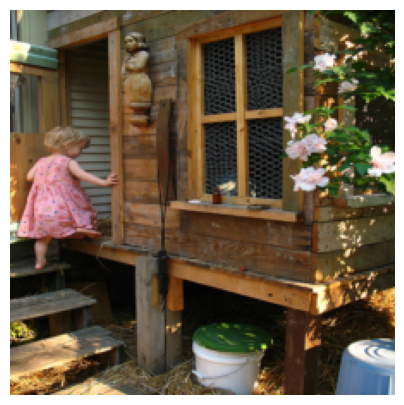

Caption: A child in a pink dress is climbing up a set of stairs in an entry way .


In [9]:
def plot_img(image, caption):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    plt.show()
    print(f"Caption: {' '.join([token for token in caption if token not in [start_token, end_token, pad_token]])}")

# get a picture and caption
full_dataset_iter = iter(Flickr8kDataset(ann))
images, caption, _ = next(full_dataset_iter)
plot_img(images, caption)

#### Den DataLoader vorbereiten
Hier passiert auch der Train-, Val-, Testsplit.

In [10]:
class Flickr8kDataModule(li.LightningDataModule):
    def __init__(self):
        super().__init__()
        
    def setup(self, stage=None):
        # split by image
        images = ann.image.unique()
        
        # calculate splitsizes
        n_images = len(images)
        n_val_samples = int(n_images * val_ratio)
        n_test_samples = int(n_images * test_ratio)

        # split
        torch.manual_seed(27112000)
        image_split = random_split(
            images,
            [
                n_images - n_val_samples - n_test_samples,
                n_val_samples,
                n_test_samples,
            ]
        )

        # retrieve image from split
        train_images = images[image_split[0].indices]
        val_images = images[image_split[1].indices]
        test_images = images[image_split[2].indices]
        
        # convert to df for dataset
        train_ann = ann[ann["image"].isin(train_images)]
        val_ann = ann[ann["image"].isin(val_images)]
        test_ann = ann[ann["image"].isin(test_images)]

        # get datasets
        self.train_dataset = Flickr8kDataset(train_ann)
        self.val_dataset = Flickr8kDataset(val_ann)
        self.test_dataset = Flickr8kDataset(test_ann)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=batch_size, num_workers=num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=batch_size, num_workers=num_workers)

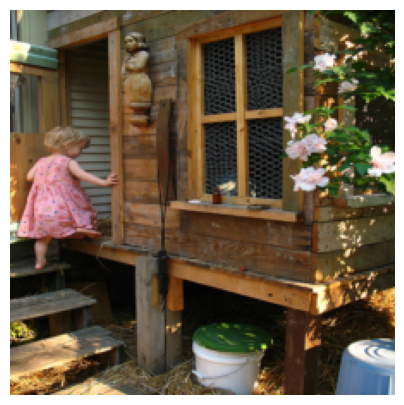

Caption: A child in a pink dress is climbing up a set of stairs in an entry way .


In [11]:
flickr8k = Flickr8kDataModule()
flickr8k.setup()

images, caption, caption_tensor = flickr8k.train_dataset[0]
plot_img(images, caption)

Seems to be working :)

### Schritt 2: Aufbau Modellierung 
Überlege Dir, welche Modell-Architektur Sinn machen könnte. Das Paper von Vinyals <br>
(https://arxiv.org/pdf/1411.4555.pdf) war wichtig in diesem Zusammenhang. du kannst <br>
Dich auf Ihre Architektur beziehen oder auch eine eigene, evt. einfachere verwenden.  <br>
Zwei Modell-Varianten sollen aufgebaut werden: 
 
Absprache/Beschluss mit Coach und Beschluss, was evaluiert werden soll. 

#### Den Encoder und Decoder vorbereiten

In [12]:
class ImageEncoder(torch.nn.Module):
    def __init__(self, cnn_model, embed_size, p_dropout):
        super().__init__()
        
        # failed sha256 check workaround: https://github.com/pytorch/vision/issues/7744
        # def get_state_dict(self, *args, **kwargs):
        #     kwargs.pop("check_hash")
        #     return torch.hub.load_state_dict_from_url(self.url, *args, **kwargs)
        # torchvision.models._api.WeightsEnum.get_state_dict = get_state_dict

        try:
            # load the model
            self.model = torchvision.models.get_model(cnn_model, weights="DEFAULT")

            # freeze all the layers
            for param in self.model.parameters():
                param.requires_grad = False

            # replace the classifier layer on efficientnet
            if cnn_model.startswith("efficientnet"):
                self.model.classifier = nn.Sequential(
                    nn.Dropout(p=p_dropout),
                    nn.Linear(self.model.classifier[-1].in_features, embed_size),
                )

            # replace the fc layer on resnet
            elif cnn_model.startswith("resnet"):
                self.model.fc = nn.Sequential(
                    nn.Dropout(p=p_dropout),
                    nn.Linear(self.model.fc.in_features, embed_size),
                )

            # replace the last classifier layer on vgg
            elif cnn_model.startswith("vgg"):
                self.model.classifier[-1] = nn.Sequential(
                    nn.Dropout(p=p_dropout),
                    nn.Linear(self.model.classifier[-1].in_features, embed_size),
                )

            # replace the head layer on vit
            elif cnn_model.startswith("vit"):
                self.model.heads.head = nn.Sequential(
                    nn.Dropout(p=p_dropout),
                    nn.Linear(self.model.heads.head.in_features, embed_size),
                )

            else:
                raise ValueError(f"Transfer Learning on Model {cnn_model} not implemented!")
            
        except Exception as e:
            raise ValueError(f"Cannot load model {cnn_model}!") from e

    def forward(self, x):
        return self.model(x)

In [13]:
class CaptionEncoder(torch.nn.Embedding):
    def __init__(self, vocab_size, embed_size):
        # initialize the nn.Embedding base class
        super().__init__(vocab_size, embed_size)

In [14]:
class CaptioningDecoder(torch.nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super().__init__()
        
        # define the LSTM layer
        self.lstm = torch.nn.LSTM(embed_size, hidden_size, num_layers)
        
        # define the output layer
        self.linear = torch.nn.Linear(hidden_size, vocab_size)
        
    def forward(self, input):
        # forward pass
        output, _ = self.lstm(input)
        output = self.linear(output)

        # softmaxing
        return torch.nn.functional.log_softmax(output, dim=-1)

#### Den Encoder und Decoder testen

In [15]:
# Parameters for testing
cnn_model = "efficientnet_b0" # list of models: torchvision.models.list_models()
embed_size = 400
p_dropout_cnn = 0.2
hidden_size_lstm = 1000
num_layers_lstm = 1

# Test Image Encoder dimensions
img_encoder = ImageEncoder(cnn_model, embed_size, p_dropout_cnn)
img_encoder_out = img_encoder(images.unsqueeze(0))
assert img_encoder(images.unsqueeze(0)).shape[1] == embed_size
print("Image Encoder: OK")
print(f"Image Encoder Output Shape: {img_encoder_out.shape}\n")

# Test Caption Encoder dimensions
cap_encoder = CaptionEncoder(vocab_size, embed_size)
cap_encoder_out = cap_encoder(caption_tensor.unsqueeze(0))
assert cap_encoder_out.shape[2] == embed_size
print("Caption Encoder: OK")
print(f"Caption Encoder Output Shape: {cap_encoder_out.shape}\n")

# Print concatenation dimensions
encoded_input = torch.cat((img_encoder_out.unsqueeze(1), cap_encoder_out), 1)
print(f"Encoded Input Shape: {encoded_input.shape}\n")

# Test Caption Decoder dimensions
cap_decoder = CaptioningDecoder(embed_size, hidden_size_lstm, vocab_size, num_layers_lstm)
cap_decoder_out = cap_decoder(encoded_input)
assert cap_decoder_out.shape[2] == vocab_size
print("Caption Decoder: OK")
print(f"Caption Decoder Output Shape: {cap_decoder_out.shape}")

Image Encoder: OK
Image Encoder Output Shape: torch.Size([1, 400])

Caption Encoder: OK
Caption Encoder Output Shape: torch.Size([1, 40, 400])

Encoded Input Shape: torch.Size([1, 41, 400])

Caption Decoder: OK
Caption Decoder Output Shape: torch.Size([1, 41, 9634])


#### Creating Model

In [85]:
class NIC(li.LightningModule):
    def __init__(self, optimizer, lr, weight_decay, cnn_model, embed_size, p_dropout_cnn, vocab_size, hidden_size_lstm, num_layers_lstm, max_caption_length):
        super().__init__()
        self.optimizer = optimizer
        self.lr = lr
        self.weight_decay = weight_decay
        self.cnn_model = cnn_model
        self.embed_size = embed_size
        self.p_dropout_cnn = p_dropout_cnn
        self.vocab_size = vocab_size
        self.hidden_size_lstm = hidden_size_lstm
        self.num_layers_lstm = num_layers_lstm
        self.max_caption_length = max_caption_length
        
        # image embedding
        self.img_encoder = ImageEncoder(self.cnn_model, self.embed_size, self.p_dropout_cnn)
        
        # word embedding
        self.caption_encoder = CaptionEncoder(self.vocab_size, self.embed_size)
        
        # caption decoding
        self.captioning_decoder = CaptioningDecoder(self.embed_size, self.hidden_size_lstm, self.vocab_size, self.num_layers_lstm)
        
        # loss function 
        self.loss_function = nn.CrossEntropyLoss()

        # metrics
        self.bleu_metric = bleu_score
        self.val_bleu_scores = defaultdict(list)
        self.test_bleu_scores = defaultdict(list)
    
    def forward(self, images, captions):
        # encode the images and captions
        embedded_images = self.img_encoder(images).unsqueeze(1)
        embedded_captions = self.caption_encoder(captions)
        
        # concatenate the features and captions
        embedded_captions = torch.cat((embedded_images, embedded_captions), 1)

        # decode the captions
        return self.captioning_decoder(embedded_captions)
    
    def generate_caption(self, images, max_caption_length=None):
        with torch.no_grad():

            # set the maximum caption length if not specified
            if max_caption_length is None:
                max_caption_length = self.max_caption_length

            # encode the images
            embedded_images = self.img_encoder(images).unsqueeze(1)

            # initialize the caption with the start token
            current_tokens = torch.tensor(tokens_str_to_int([start_token]), device=images.device)
            current_tokens = current_tokens.repeat(len(images), 1)

            for _ in range(max_caption_length-1):
                # encode the current tokens
                embedded_captions = self.caption_encoder(current_tokens)
                embedded_captions = torch.cat((embedded_images, embedded_captions), 1)
                
                # decode the captions
                output = self.captioning_decoder(embedded_captions).argmax(dim=-1)

                # append the predicted token to the current tokens
                current_tokens = torch.cat((current_tokens, output[:,-1:]), 1)


            return current_tokens
        
    def _step(self, batch, batch_idx):
        # forward pass
        images, _, captions = batch
        outputs = self(images, captions)
        outputs = outputs[:, :-1, :] # remove last token, because it is not used as input
        outputs = outputs.permute(0, 2, 1) # permute for the loss function

        # return loss
        return self.loss_function(outputs, captions)
    
    def _metrics_step(self, batch, batch_idx):
        # forward pass
        with torch.no_grad():
            images, captions, _ = batch
            captions = list(zip(*captions)) # transpose captions, so they can be processed in parallel
            outputs = self.generate_caption(images, max_caption_length=self.max_caption_length, cancel_on_end_token=False)
            outputs = [tokens_int_to_str(caption) for caption in outputs.tolist()]
            bleu1 = self.bleu_metric(outputs, captions, max_n=1, weights=[1])
            bleu2 = self.bleu_metric(outputs, captions, max_n=2, weights=[1/2, 1/2])
            bleu3 = self.bleu_metric(outputs, captions, max_n=3, weights=[1/3, 1/3, 1/3])
            bleu4 = self.bleu_metric(outputs, captions, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

        return bleu1, bleu2, bleu3, bleu4
            
    def training_step(self, batch, _):
        loss = self._step(batch, _)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, _):
        loss = self._step(batch, _)
        self.log('val_loss', loss)

        bleu1, bleu2, bleu3, bleu4 = self._metrics_step(batch, _)
        self.val_bleu_scores["bleu1"].append(bleu1)
        self.val_bleu_scores["bleu2"].append(bleu2)
        self.val_bleu_scores["bleu3"].append(bleu3)
        self.val_bleu_scores["bleu4"].append(bleu4)

    def on_validation_epoch_end(self):
        self.log_dict({f"val_{key}": torch.tensor(values).mean() for key, values in self.val_bleu_scores.items()})
        self.val_bleu_scores = defaultdict(list)

    def test_step(self, batch, _):
        loss = self._step(batch, _)
        self.log('test_loss', loss)
        
        bleu1, bleu2, bleu3, bleu4 = self._metrics_step(batch, _)
        self.test_bleu_scores["bleu1"].append(bleu1)
        self.test_bleu_scores["bleu2"].append(bleu2)
        self.test_bleu_scores["bleu3"].append(bleu3)
        self.test_bleu_scores["bleu4"].append(bleu4)

    def on_test_epoch_end(self):
        self.log_dict({f"test_{key}": torch.tensor(values).mean() for key, values in self.test_bleu_scores.items()})
        self.test_bleu_scores = defaultdict(list)

    def configure_optimizers(self):
        # define the optimizer
        match self.optimizer:
            case "SGD":
                return torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
            case "Adam":
                return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay) 
            case "AdamW":
                return torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
            case _:
                raise ValueError(f"Optimizer {self.optimizer} not supported!")

#### Example run

In [89]:
model = NIC(
    optimizer="Adam",
    lr=0.001,
    weight_decay=0.0001,
    cnn_model="resnet18",
    embed_size=400,
    p_dropout_cnn=0.2,
    vocab_size=vocab_size,
    hidden_size_lstm=1000,
    num_layers_lstm=1,
    max_caption_length=max_num_tokens,
)

wandb_logger = li.loggers.WandbLogger(log_model='all')

trainer = li.Trainer(
    max_epochs=1,
    logger=wandb_logger,
    log_every_n_steps=1,
    fast_dev_run=60,
)
 
wandb_logger.watch(model)

trainer.fit(model, flickr8k.train_dataloader())#, flickr8k.val_dataloader())

wandb.finish()

Training: |          | 0/? [00:00<?, ?it/s]

### Schritt 3: Training und Evaluation 
Trainiere und evaluiere das Modell. Beschreibe genau was Du tust und warum Du es tust. 

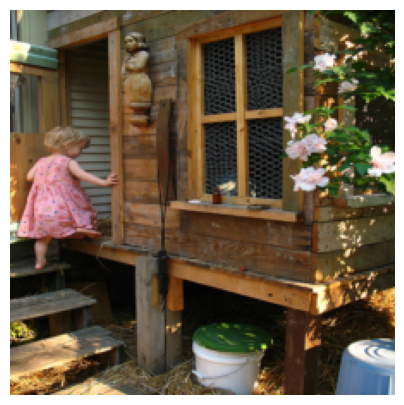

Caption: A child in a pink dress is climbing up a set of stairs in an entry way .
Prediction: A man in a red




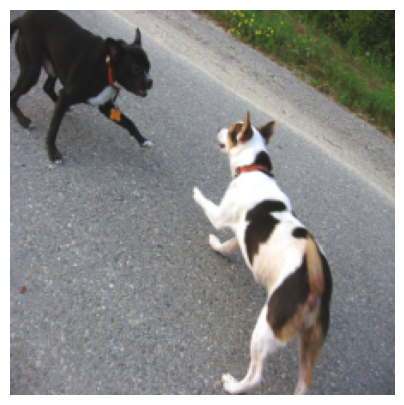

Caption: A black dog and a spotted dog are fighting
Prediction: A man in a red




In [107]:
# Print an example prediction
# Put model in evaluation mode
model.eval()

for i in range(2):
    images, caption, _ = flickr8k.train_dataset[i * 5]
    output = model.generate_caption(images.unsqueeze(0), 20)
    output = tokens_int_to_str(output.tolist()[0])
    plot_img(images, caption)
    print(f"Prediction: {' '.join([token for token in output if token not in [start_token, end_token, pad_token]])}\n")
    print()

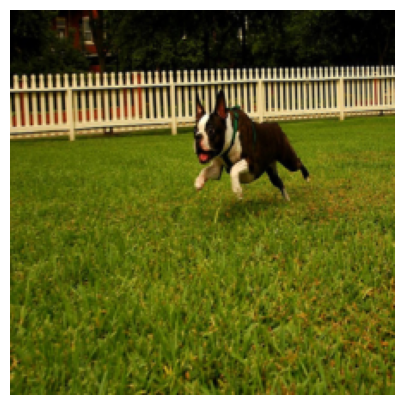

Caption: A black and white dog is running in a grassy garden surrounded by a white fence .
Prediction: A man in a red




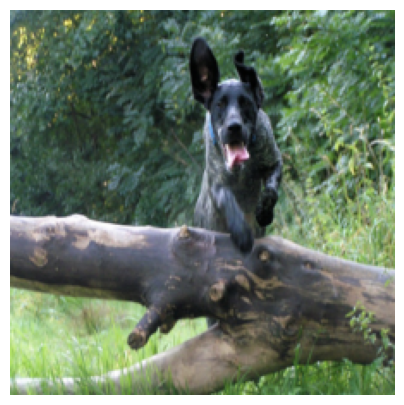

Caption: A black dog leaps over a log .
Prediction: A man in a red




In [92]:
for i in range(2):
    images, caption, _ = flickr8k.val_dataset[i * 5]
    output = model.generate_caption(images.unsqueeze(0), 20)
    output = tokens_int_to_str(output.tolist()[0])
    plot_img(images, caption)
    print(f"Prediction: {' '.join([token for token in output if token not in [start_token, end_token, pad_token]])}\n")
    print()

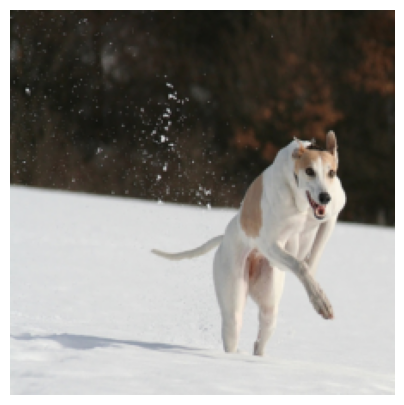

Caption: A brown and white dog is running through the snow .
Prediction: A man in a red




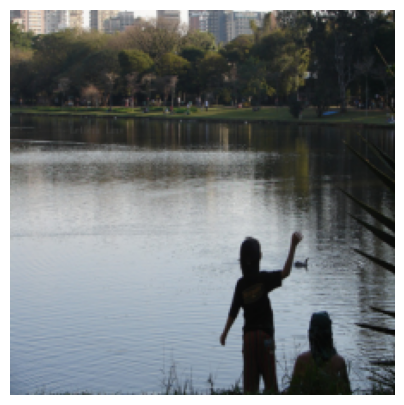

Caption: A child and a woman are at waters edge in a big city .
Prediction: A man in a red




In [93]:
for i in range(2):
    images, caption, _ = flickr8k.test_dataset[i * 5]
    output = model.generate_caption(images.unsqueeze(0), 20)
    output = tokens_int_to_str(output.tolist()[0])
    plot_img(images, caption)
    print(f"Prediction: {' '.join([token for token in output if token not in [start_token, end_token, pad_token]])}\n")
    print()

### Schritt 4: Präsentation / Bericht 
- Präsentation (~10m): Kurze Präsentation mit Diskussion der wichtigsten Ergebnisse. <br> 
- Q&A (~10min): Klärung von Verständnisfragen zum Paper und der Umsetzung. <br>
- Bericht in Form eines gut dokumentierten, übersichtlichen Jupyter Notebooks. 

Dieses soll schliesslich auch abgegeben werden und dem Fachexperten erlauben, die <br>
Schritte nachzuvollziehen (allenfalls auch das Training erneut laufen zu lassen). <br>

## Beurteilung 
Beurteilt wird auf Basis des abgegebenen Notebooks:  
- Vollständige und korrekte Umsetzung der vereinbarten Aufgabestellung. 
- Klare, gut-strukturierte Umsetzung.  
- Schlüssige Beschreibung und Interpretation der Ergebnisse. Gut gewählte und gut <br> kommentierten Plots und Tabellen. 
- Vernünftiger Umgang mit (Computing-)Ressourcen. 
- Verständliche Präsentation der Ergebnisse.

## Referenzen, Key Words 
- Word Embedding (z.B. word2vec, glove), um Wörter in numerische Vektoren in einem <br> geeignet dimensionierten Raum zu mappen. Siehe z.B. Andrew Ng, Coursera: <br>https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s  
- Bild Embedding mittels vortrainierten (evt. retrained) Netzwerken wie beispielsweise <br>ResNet, GoogLeNet, EfficientNet oder ähnlich. Transfer-Learning. 
- Seq2Seq Models bekannt für Sprach-Übersetzung.  